In [1]:

# """
# From a directory of multiple files of a particular format, retain only n files!

# """


# import os
# import random
# from pathlib import Path

# cwd = Path.cwd()

# random_files = random.sample([file for file in cwd.iterdir() if ".PNG" in str(file)], k=100)  
# # choose k numbers without replacement from given population, use random.choices for with replacement

# random_files = set(random_files)   # set for easy look-up later

# for index, file in enumerate(cwd.iterdir()):
#     if file not in random_files and ".PNG" in str(file):  #only remove those files not in random and those are .PNG
#         Path.unlink(file)    

# print(len([f for f in cwd.iterdir()]))  #checking folder size later!

In [48]:
"""
Parsing a xml file (possibly CV2 output) using Python

"""

def convert_xml_to_dict(xml_file ="sim-PSM1-2016Feb05T175836.xml"):
    """Convert given xml to structure as follows
        
    """
    import numpy as np
    import xml.etree.ElementTree as ET
    from collections import defaultdict

    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    root_dict = dict()
    
    root_dict["framecount"] = int(root[0].text)
    
    for part in root[1:4]: # 'J4_poses', 'J5_poses', 'bHe_poses'
        
        root_dict[part.tag] = [0]*root_dict["framecount"]
        
        for frame in range(root_dict["framecount"]):
            data = part[frame][3].text
            data_arr = np.array(list(map(float, data.split()))).reshape(4,4)
            root_dict[part.tag][frame] = data_arr
    
    for part in root[4:]: # "jaws"
        root_dict[part.tag] = list(map(float, part.text.split()))
        
    return root_dict

In [36]:
# PSM1_dict = convert_xml_to_dict(xml_file ="sim-PSM1-2016Feb05T175836.xml")

In [49]:
PSM2_dict = convert_xml_to_dict(xml_file ="sim-PSM2-2016Feb05T175836.xml")

In [50]:
# PSM1_dict.keys()

In [51]:
PSM2_dict.keys()

dict_keys(['framecount', 'J4_poses', 'J5_poses', 'bHe_poses', 'jaws'])

In [52]:
import transforms3d
import matplotlib.pyplot as plt
import numpy as np

In [53]:
tool_tip = np.array([0 ,-1, 0, 0,0, 0, 1, 0,-1, 0, 0, 0, 0, 0, 0, 1]).reshape(4,4)
print(tool_tip)

[[ 0 -1  0  0]
 [ 0  0  1  0]
 [-1  0  0  0]
 [ 0  0  0  1]]


In [55]:
PSM1_dict = PSM2_dict   #CHANGE THIS LATER, WRITING THIS BECAUSE FR HAS HARDCODED PSM1_dict IN THE BELOW CELL

In [56]:
Joint_1_angle_values = [0]*PSM1_dict["framecount"]
Joint_2_angle_values = [0]*PSM1_dict["framecount"]
Joint_3_angle_values = [0]*PSM1_dict["framecount"]
Joint_4_angle_values = [0]*PSM1_dict["framecount"]
Joint_5_angle_values = [0]*PSM1_dict["framecount"]
Joint_6_angle_values = [0]*PSM1_dict["framecount"]
Joint_7_angle_values = PSM1_dict["jaws"]

for frame_index, T_b_4 in enumerate(PSM1_dict["J4_poses"]):
    #Get joint angles 1,2,4
    T_b_4 = np.dot(T_b_4, np.linalg.inv(tool_tip))
    
    joint_angle_4 = np.arctan2(-T_b_4[1,1], T_b_4[1,0])
    joint_angle_2 = np.arctan2(  T_b_4[1,0]/np.cos(joint_angle_4), -T_b_4[1,2])
    joint_angle_1 = np.arctan2(T_b_4[2,2]/np.sin(joint_angle_2), T_b_4[0,2]/np.sin(joint_angle_2))
    
    Joint_1_angle_values[frame_index] = joint_angle_1 - np.pi/2.0
    Joint_2_angle_values[frame_index] = joint_angle_2 + np.pi/2.0
    Joint_4_angle_values[frame_index] = joint_angle_4
    
    #Get joint angle 3
    p = T_b_4[:3, -1]
    norm = np.linalg.norm(p)
    joint_angle_3 = (norm  + 431.8 - 416.2)/1000 # in m  (lRCC + ltool From User_Guide_DVRK)
    Joint_3_angle_values[frame_index] = joint_angle_3
    
    #Get joint angle 5
    T_b_5 = PSM1_dict["J5_poses"][frame_index]
    T_b_5 = np.dot(T_b_5, np.linalg.inv(tool_tip))

    T_4_5 = np.dot(np.linalg.inv(T_b_4), T_b_5)

    Joint_5_angle_values[frame_index] = np.arctan2(-T_4_5[0,1], T_4_5[0,0]) + np.pi/2.0

    #Get joint angle 6
    T_b_6 = PSM1_dict["bHe_poses"][frame_index]
    T_b_6 = np.dot(T_b_6, np.linalg.inv(tool_tip))
    
    T_5_6 = np.dot(np.linalg.inv(T_b_5), T_b_6) 
    Joint_6_angle_values[frame_index] = np.arctan2(-T_5_6[0,1], T_5_6[0,0]) + np.pi/2.0

In [44]:
# PSM1_joint_angles = np.vstack((Joint_1_angle_values, Joint_2_angle_values, Joint_3_angle_values, 
#                                Joint_4_angle_values, Joint_5_angle_values, Joint_6_angle_values,
#                               Joint_7_angle_values))

In [57]:
PSM2_joint_angles = np.vstack((Joint_1_angle_values, Joint_2_angle_values, Joint_3_angle_values, 
                               Joint_4_angle_values, Joint_5_angle_values, Joint_6_angle_values,
                              Joint_7_angle_values))

In [45]:
# PSM1_joint_angles.shape

(7, 373)

In [46]:
# PSM1_joint_angles

array([[-3.26319113, -3.26319885, -3.26335331, ..., -3.25865789,
        -3.25865789, -3.25865789],
       [ 3.26739192,  3.26737648,  3.2673842 , ...,  3.30035255,
         3.30035255,  3.30035255],
       [ 0.12137163,  0.12136904,  0.12136515, ...,  0.1186909 ,
         0.1186909 ,  0.1186909 ],
       ...,
       [ 0.41605447,  0.41605447,  0.41619111, ...,  0.47562798,
         0.47562798,  0.47549135],
       [-0.32277208, -0.32277208, -0.32255679, ..., -0.51355298,
        -0.51355298, -0.51352324],
       [-0.34596273, -0.34596273, -0.34596273, ..., -0.34579939,
        -0.34579939, -0.34563604]])

In [47]:
# np.save("PSM1_joint_angles.npy", PSM1_joint_angles)

In [58]:
np.save("PSM2_joint_angles.npy", PSM2_joint_angles)

In [59]:
PSM2_joint_angles

array([[-3.47286333, -3.47233818, -3.47233046, ..., -3.46127923,
        -3.46127923, -3.46126378],
       [ 3.37204268,  3.37218168,  3.37217396, ...,  3.41039377,
         3.41039377,  3.41039377],
       [ 0.14179598,  0.14179079,  0.1417869 , ...,  0.1388534 ,
         0.1388534 ,  0.1388534 ],
       ...,
       [-0.09250658, -0.08991049, -0.09018376, ..., -0.21493289,
        -0.21493289, -0.21479625],
       [ 0.08179719,  0.0840909 ,  0.08210841, ..., -0.15341856,
        -0.15341856, -0.15385669],
       [-0.34824955, -0.34857625, -0.34906626, ..., -0.34890291,
        -0.34890291, -0.34890291]])

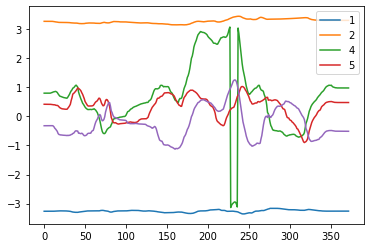

In [7]:
# DON'T RUN THIS CELL!
#PSM1 Joint angles

# plt.plot(Joint_1_angle_values)
# plt.plot(Joint_2_angle_values)
# plt.plot(Joint_4_angle_values)
# plt.plot(Joint_5_angle_values)
# plt.plot(Joint_6_angle_values)


# plt.legend([1,2,4,5], loc="best")
# plt.show()

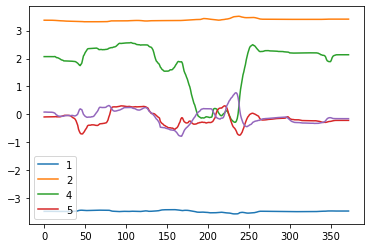

In [27]:
#PSM2 Angles

plt.plot(Joint_1_angle_values)
plt.plot(Joint_2_angle_values)
plt.plot(Joint_4_angle_values)
plt.plot(Joint_5_angle_values)
plt.plot(Joint_6_angle_values)


plt.legend([1,2,4,5], loc="best")
plt.show()

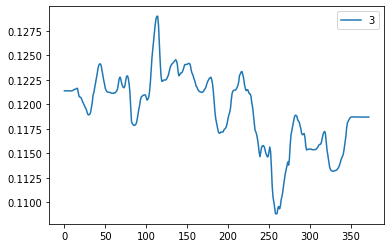

In [8]:
#DON'T RUN THIS CELL!
#PSM1
# plt.plot(Joint_3_angle_values)
# plt.legend([3], loc="best")
# plt.show()

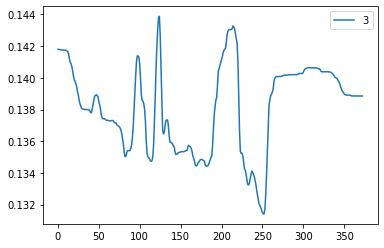

In [28]:
plt.plot(Joint_3_angle_values)
plt.legend([3], loc="best")
plt.show()

In [61]:
def getJointTransform(a, alpha, D, theta):
    ca = np.cos(alpha)
    sa = np.sin(alpha)
    
    ct = np.cos(theta)
    st = np.sin(theta)
    
    T_x = np.array([[1, 0, 0, a],
                    [0,ca,-sa,0],
                    [0,sa, ca,0],
                    [0, 0, 0, 1]]);
    
    T_z = np.array([[ct, -st, 0, 0],
                    [st,  ct, 0, 0],
                    [0 ,   0, 1, D],
                    [0 ,   0, 0, 1]]);
    return np.dot(T_x, T_z)

In [62]:
index = 200

j1 = Joint_1_angle_values[index] 
j2 = Joint_2_angle_values[index] 
j3 = Joint_3_angle_values[index]
j4 = Joint_4_angle_values[index]
j5 = Joint_5_angle_values[index]
j6 = Joint_6_angle_values[index]


T_0_1 = getJointTransform(0, np.pi/2, 0, j1 + np.pi/2.0)
T_1_2 = getJointTransform(0,-np.pi/2, 0, j2 - np.pi/2.0)
T_2_3 = getJointTransform(0, np.pi/2, j3 - 0.4318, 0)
T_3_4 = getJointTransform(0, 0, 0.4162, j4)

T_0_4 = np.dot(np.dot( np.dot(T_0_1, T_1_2), T_2_3), T_3_4)
T_0_4[:3, 3] *= 1000

print("Forward Kin T_b_4: ")
print(T_0_4)
print("XML T_b_4: ")
print(np.dot(PSM1_dict["J4_poses"][index], np.linalg.inv(tool_tip)))

T_4_5 = getJointTransform(0, -np.pi/2, 0, j5 - np.pi/2.0)
T_0_5 = np.dot(T_0_4, T_4_5)
print("Forward Kin T_b_5: ")
print(T_0_5)
print("XML T_b_5: ")
print(np.dot(PSM1_dict["J5_poses"][index], np.linalg.inv(tool_tip)))

T_5_6 = getJointTransform(0.0091*1000, -np.pi/2, 0, j6 - np.pi/2.0)
T_0_6 = np.dot(T_0_5, T_5_6)
print("Forward Kin T_b_6: ")
print(T_0_6)
print("XML T_b_6: ")
print(np.dot(PSM1_dict["bHe_poses"][index], np.linalg.inv(tool_tip)))


Forward Kin T_b_4: 
[[ 1.24747684e-02  9.37227093e-01 -3.48496421e-01 -4.37466459e+01]
 [ 9.57546604e-01  8.91884629e-02  2.74134855e-01  3.44120620e+01]
 [ 2.88008474e-01 -3.37121334e-01 -8.96326015e-01 -1.12515522e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
XML T_b_4: 
[[ 1.24747684e-02  9.37227093e-01 -3.48496421e-01 -4.37466459e+01]
 [ 9.57546604e-01  8.91884629e-02  2.74134855e-01  3.44120620e+01]
 [ 2.88008474e-01 -3.37121334e-01 -8.96326015e-01 -1.12515522e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Forward Kin T_b_5: 
[[-3.37190687e-01 -8.89259022e-02  9.37227093e-01 -4.37466459e+01]
 [-1.47452516e-02  9.95905616e-01  8.91884629e-02  3.44120620e+01]
 [-9.41320890e-01  1.62538697e-02 -3.37121334e-01 -1.12515522e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
XML T_b_5: 
[[-3.37190687e-01 -8.89259022e-02  9.37227093e-01 -4.37466459e+01]
 [-1.47452516e-02  9.95905616e-01  8.91884629e-02  3.44120620e

In [151]:
print(np.dot(PSM1_dict["J4_poses"][index], np.linalg.inv(tool_tip)))

[[ 4.90207033e-02  9.92949256e-01 -1.07929351e-01 -1.13421323e+01]
 [ 9.93856073e-01 -3.77566524e-02  1.04041056e-01  1.09335173e+01]
 [ 9.92324386e-02 -1.12366407e-01 -9.88699506e-01 -1.03900936e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [54]:
from sympy import *

def getSimpyTransform(a, alpha, D, theta):
    ca = cos(alpha)
    sa = sin(alpha)
    
    ct = cos(theta)
    st = sin(theta)
    
    T_x = Matrix(  [[1, 0, 0, a],
                    [0,ca,-sa,0],
                    [0,sa, ca,0],
                    [0, 0, 0, 1]]);
    
    T_z = Matrix  ([[ct, -st, 0, 0],
                    [st,  ct, 0, 0],
                    [0 ,   0, 1, D],
                    [0 ,   0, 0, 1]]);
    return T_x*T_z

In [103]:
q1, q2, q3, q4 = symbols('q1, q2, q3, q4')


T_0_1 = getSimpyTransform(0, np.pi/2, 0, q1 )
T_1_2 = getSimpyTransform(0,-np.pi/2, 0, q2)
T_2_3 = getSimpyTransform(0, np.pi/2, q3, 0)
T_3_4 = getSimpyTransform(0, 0, 0.4162, q4)

T_0_4 = T_0_1*T_1_2*T_2_3*T_3_4

In [105]:
print(T_0_4[2,2])

1.0*sin(q1)*sin(q2) - 6.12323399573677e-17*cos(q1)*cos(q2) + 6.12323399573677e-17*cos(q1) + 6.12323399573677e-17*cos(q2) + 2.29584502165847e-49


In [53]:
list(map(len, [Joint_1_angle_values,Joint_2_angle_values, Joint_3_angle_values, 
           Joint_4_angle_values, Joint_5_roll_yaw_pitch_angles, Joint_6_roll_yaw_pitch_angles]))

[373, 373, 373, 373, 373, 373]

In [363]:
import pickle
with open("Joint_Angles_List.pkl", "wb") as f:
    list_of_6_joints = [Joint_1_angle_values,
                        Joint_2_angle_values, 
                        Joint_3_angle_values, 
                        Joint_4_angle_values, 
                        Joint_5_roll_yaw_pitch_angles,
                        Joint_6_roll_yaw_pitch_angles]
    pickle.dump(list_of_6_joints, f)

In [364]:
with open("Joint_Angles_List.pkl", "rb") as f:
    list_check = pickle.load(f)

In [367]:
Joint_1_angle_values

[-3.0148675246262253,
 -3.014882963025442,
 -3.014872816757055,
 -3.0148544138567175,
 -3.0148544138567175,
 -3.0148545325242306,
 -3.014854651184044,
 -3.014854769836159,
 -3.0148657489928032,
 -3.0150598673810336,
 -3.0161800210000798,
 -3.0192797957432362,
 -3.02410913448039,
 -3.0301379631042002,
 -3.034795702377429,
 -3.037642669094328,
 -3.042233312104333,
 -3.0485954438196337,
 -3.0521810145834416,
 -3.0529554755494015,
 -3.0535452966534247,
 -3.053614763873482,
 -3.054056422370952,
 -3.0553548888149464,
 -3.0558082937859656,
 -3.0562944007151107,
 -3.0565207283275617,
 -3.0565510298320717,
 -3.0563776571287686,
 -3.0564838239530183,
 -3.0579309874856913,
 -3.060058746920432,
 -3.0618664377464886,
 -3.066866817180352,
 -3.0697280938660154,
 -3.07387667388711,
 -3.0747648053670633,
 -3.0749215528545144,
 -3.074811114282127,
 -3.074803741293833,
 -3.0765146858121333,
 -3.082651844485608,
 -3.0895776348772506,
 -3.091415331253113,
 -3.093800241248443,
 -3.0944867517263415,
 -3.0948